In [1]:
# Copyright (c) 2018-present, Royal Bank of Canada.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F

from advertorch.utils import predict_from_logits
from advertorch_examples.utils import get_mnist_test_loader
from advertorch_examples.utils import _imshow

torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Load model that is trained with `tut_train_mnist.py`

In [4]:
# # need to use python 3.6 for the tensorflow checking part
# from advertorch.test_utils import LeNet5
# from advertorch_examples.utils import TRAINED_MODEL_PATH

# filename = "mnist_lenet5_clntrained.pt"
# # filename = "mnist_lenet5_advtrained.pt"

# model = LeNet5()
# model.load_state_dict(
#     torch.load(os.path.join(TRAINED_MODEL_PATH, filename)))
# model.to(device)
# model.eval()

In [13]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        y = x
        x = self.fc2(x)
        return y

    def name(self):
        return "LeNet"


## training
model = LeNet()
model.load_state_dict(
    torch.load('LeNet'))

### Load data

In [8]:
batch_size = 5
loader = get_mnist_test_loader(batch_size=batch_size)
for cln_data, true_label in loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

1.3%

100.1%

Extracting C:\ProgramData\Anaconda3\envs\torch36\lib\site-packages\advertorch_examples\data\mnist\MNIST\raw\train-images-idx3-ubyte.gz


0.5%

Extracting C:\ProgramData\Anaconda3\envs\torch36\lib\site-packages\advertorch_examples\data\mnist\MNIST\raw\train-labels-idx1-ubyte.gz


180.4%

Extracting C:\ProgramData\Anaconda3\envs\torch36\lib\site-packages\advertorch_examples\data\mnist\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting C:\ProgramData\Anaconda3\envs\torch36\lib\site-packages\advertorch_examples\data\mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz
Processing...
Done!


### Construct a LinfPGDAttack adversary instance

In [14]:
from advertorch.attacks import LinfPGDAttack

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
    nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

### Perform untargeted attack

In [15]:
adv_untargeted = adversary.perturb(cln_data, true_label)

### Perform targeted attack

In [16]:
target = torch.ones_like(true_label) * 3
adversary.targeted = True
adv_targeted = adversary.perturb(cln_data, target)

### Visualization of attacks

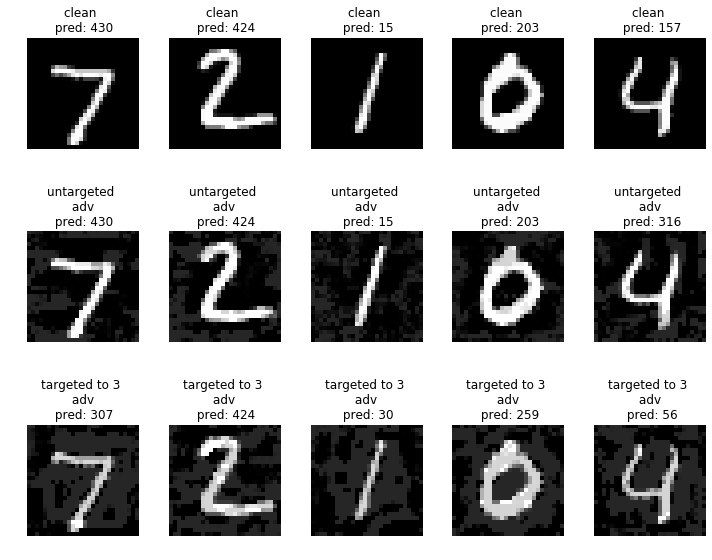

In [17]:
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted_adv = predict_from_logits(model(adv_untargeted))
pred_targeted_adv = predict_from_logits(model(adv_targeted))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for ii in range(batch_size):
    plt.subplot(3, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size * 2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3 \n adv \n pred: {}".format(
        pred_targeted_adv[ii]))

plt.tight_layout()
plt.show()

### Construct defenses based on preprocessing

In [18]:
from advertorch.defenses import MedianSmoothing2D
from advertorch.defenses import BitSqueezing
from advertorch.defenses import JPEGFilter

bits_squeezing = BitSqueezing(bit_depth=5)
median_filter = MedianSmoothing2D(kernel_size=3)
jpeg_filter = JPEGFilter(10)

defense = nn.Sequential(
    jpeg_filter,
    bits_squeezing,
    median_filter,
)

### Process the inputs using the defense
here we use the previous untargeted attack as the running example. 

In [19]:
adv = adv_untargeted
adv_defended = defense(adv)
cln_defended = defense(cln_data)

C:\ProgramData\Anaconda3\envs\torch36\lib\site-packages\advertorch\functional.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  return x.new_tensor(torch.stack(lst_img))


### Visualization of defenses

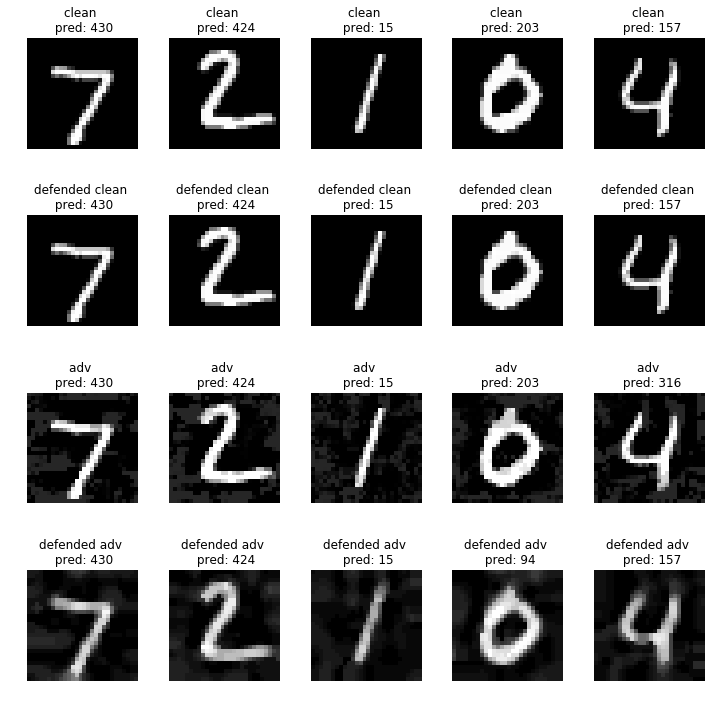

In [20]:
pred_cln = predict_from_logits(model(cln_data))
pred_cln_defended = predict_from_logits(model(cln_defended))
pred_adv = predict_from_logits(model(adv))
pred_adv_defended = predict_from_logits(model(adv_defended))


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for ii in range(batch_size):
    plt.subplot(4, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(4, batch_size, ii + 1 + batch_size)
    _imshow(cln_data[ii])
    plt.title("defended clean \n pred: {}".format(pred_cln_defended[ii]))
    plt.subplot(4, batch_size, ii + 1 + batch_size * 2)
    _imshow(adv[ii])
    plt.title("adv \n pred: {}".format(
        pred_adv[ii]))
    plt.subplot(4, batch_size, ii + 1 + batch_size * 3)
    _imshow(adv_defended[ii])
    plt.title("defended adv \n pred: {}".format(
        pred_adv_defended[ii]))

plt.tight_layout()
plt.show()

### BPDA (Backward Pass Differentiable Approximation)
BPDA is a method proposed in [1], which can be used to attack non-differentiable preprocessing based defenses. Here we use $f(x)$ to denote a non-differentiable component, and $g(x)$ to denote a differentiable component that is similar to $f(x)$. In BPDA, $f(x)$ is used in forward computation, and in the backward computation $g(x)$ is used to propagate down the gradients.

Here we use BPDA to perform adaptive attack towards the defenses we used above.

[1] Athalye, A., Carlini, N. & Wagner, D.. (2018). Obfuscated Gradients Give a False Sense of Security: Circumventing Defenses to Adversarial Examples. Proceedings of the 35th International Conference on Machine Learning, in PMLR 80:274-283

In [11]:
from advertorch.bpda import BPDAWrapper
defense_withbpda = BPDAWrapper(defense, forwardsub=lambda x: x)
defended_model = nn.Sequential(defense_withbpda, model)
bpda_adversary = LinfPGDAttack(
    defended_model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
    nb_iter=1000, eps_iter=0.005, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)


bpda_adv = bpda_adversary.perturb(cln_data, true_label)
bpda_adv_defended = defense(bpda_adv)

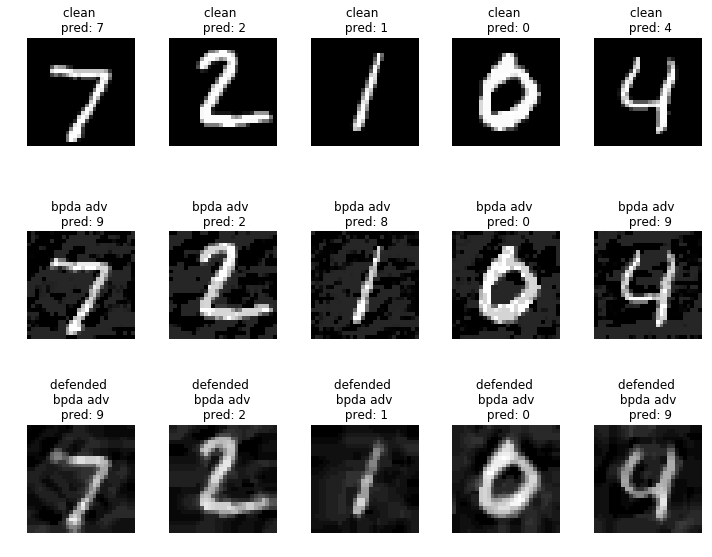

In [12]:
pred_cln = predict_from_logits(model(cln_data))
pred_bpda_adv = predict_from_logits(model(bpda_adv))
pred_bpda_adv_defended = predict_from_logits(model(bpda_adv_defended))


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for ii in range(batch_size):
    plt.subplot(3, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size)
    _imshow(bpda_adv[ii])
    plt.title("bpda adv \n pred: {}".format(
        pred_bpda_adv[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size * 2)
    _imshow(bpda_adv_defended[ii])
    plt.title("defended \n bpda adv \n pred: {}".format(
        pred_bpda_adv_defended[ii]))

plt.tight_layout()
plt.show()
